In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import regress, zscore, fdr, threshold, correlation, correlation_permutation, isc
from nltools.file_reader import onsets_to_dm
from nltools.external import glover_hrf
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from sklearn.metrics import pairwise_distances
from scipy.stats import binom, ttest_1samp, pearsonr

from sklearn.utils import check_random_state
from joblib import Parallel, delayed
from nltools.stats import _calc_pvalue
from numpy.fft import fft, ifft

base_dir = '/Volumes/Engram/Data/Sherlock/fmriprep'

/Users/lukechang/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data

In [69]:
sub_list = [os.path.basename(x).split('_')[0] for x in glob.glob(os.path.join(base_dir, '*', 'func', '*Part1*csv'))]
sub_list.sort()

sub_timeseries = {}
for sub in sub_list:
    part1 = pd.read_csv(os.path.join(base_dir, sub, 'func', f'{sub}_Part1_Average_ROI_n50.csv'))
    part2 = pd.read_csv(os.path.join(base_dir, sub, 'func', f'{sub}_Part2_Average_ROI_n50.csv'))
    sub_data = part1.append(part2)
    sub_data.reset_index(inplace=True, drop=True)
    sub_timeseries[sub] = sub_data

In [2]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)

In [10]:
isc_r = {}
isc_p = {}
for roi in range(50):
    sub_rois = {}
    for sub in sub_timeseries:
        sub_rois[sub] = sub_timeseries[sub].iloc[:, roi]
    sub_rois = pd.DataFrame(sub_rois)
    time_dist = Adjacency(1 - pairwise_distances(sub_rois.T, metric='correlation'), matrix_type='similarity')
    stats = time_dist.isc()
    isc_r[roi] = stats['isc']
    isc_p[roi] = stats['p']
isc_r_brain = roi_to_brain(pd.Series(isc_r), mask_x)
isc_p_brain = roi_to_brain(pd.Series(isc_p), mask_x)

In [9]:
isc_r_brain = roi_to_brain(pd.Series(isc_r), mask_x)
isc_p_brain = roi_to_brain(pd.Series(isc_p), mask_x)

FDR: 0.02419516096780644


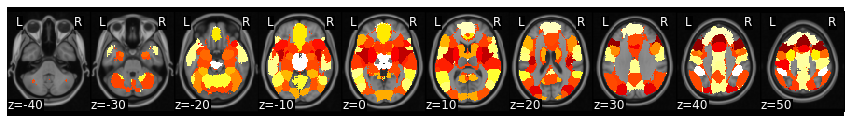

In [7]:
cutoff = fdr(isc_p_brain.data, .05)
isc_thresholded = threshold(isc_r_brain, isc_p_brain, cutoff)
print(f'FDR: {cutoff}')
isc_thresholded.plot()

In [10]:
scan = 'Part1'
file_list = glob.glob(os.path.join(base_dir, '*', 'func', f'*crop*{scan}*hdf5'))

extract_metric = 'mean'
isc_metric = 'median'
n_bootstraps = 5000
ci_percentile = 95
extraction = 'time'
data_type = 'brain_files'

if data_type == 'brain_files':
    mask_x = expand_mask(mask)
    
    all_roi = []
    f = file_list[0]
    for f in file_list:
        data = Brain_Data(f)
        all_roi.append(pd.DataFrame(data.extract_roi(mask, metric=extract_metric).T))

    isc_r = {}
    isc_p = {}
    for roi in range(len(mask_x)):
        combined_roi = []
        for sub_dat in all_roi:
            combined_roi.append(sub_dat.iloc[:, roi])
        combined_roi = pd.DataFrame(combined_roi)
        similarity = Adjacency(1 - pairwise_distances(combined_roi, metric='correlation'), matrix_type='similarity')
        stats = similarity.isc(metric=isc_metric, n_bootstraps=n_bootstraps)
        isc_r[roi] = stats['isc']
        isc_p[roi] = stats['p']
    isc_r_brain = roi_to_brain(pd.Series(isc_r), mask_x)
    isc_p_brain = roi_to_brain(pd.Series(isc_p), mask_x)
    
    out = {}
    isc_r = {}
    isc_p = {}
    isc_ci_lower = {}
    isc_ci_upper = {}
    for roi in range(len(mask_x)):
        combined_roi = []
        for sub_dat in all_roi:
            combined_roi.append(sub_dat.iloc[:, roi])
        combined_roi = pd.DataFrame(combined_roi)
        similarity = Adjacency(1 - pairwise_distances(combined_roi, metric='correlation'), matrix_type='similarity')
        stats = similarity.isc()
        isc_r[roi] = stats['isc']
        isc_p[roi] = stats['p']
        isc_ci_lower[roi] = stats['ci'][0]
        isc_ci_upper[roi] = stats['ci'][1]
    out['isc_r_brain'] = roi_to_brain(pd.Series(isc_r), mask_x)
    out['isc_p_brain'] = roi_to_brain(pd.Series(isc_p), mask_x)
    out['isc_ci_lower_brain'] = roi_to_brain(pd.Series(isc_ci_lower), mask_x)
    out['isc_ci_upper_brain'] = roi_to_brain(pd.Series(isc_ci_upper), mask_x)

In [24]:
out = {}
isc_r = {}
isc_p = {}
isc_ci_lower = {}
isc_ci_upper = {}
for roi in range(len(mask_x)):
    combined_roi = []
    for sub_dat in all_roi:
        combined_roi.append(sub_dat.iloc[:, roi])
    combined_roi = pd.DataFrame(combined_roi)
    similarity = Adjacency(1 - pairwise_distances(combined_roi, metric='correlation'), matrix_type='similarity')
    stats = similarity.isc()
    isc_r[roi] = stats['isc']
    isc_p[roi] = stats['p']
    isc_ci_lower[roi] = stats['ci'][0]
    isc_ci_upper[roi] = stats['ci'][1]
out['isc_r_brain'] = roi_to_brain(pd.Series(isc_r), mask_x)
out['isc_p_brain'] = roi_to_brain(pd.Series(isc_p), mask_x)
out['isc_ci_lower_brain'] = roi_to_brain(pd.Series(isc_ci_lower), mask_x)
out['isc_ci_upper_brain'] = roi_to_brain(pd.Series(isc_ci_upper), mask_x)

Exception ignored in: <function _after_fork at 0x7fa040360e60>
Traceback (most recent call last):
  File "/Users/lukechang/anaconda3/lib/python3.7/threading.py", line 1367, in _after_fork
    thread._reset_internal_locks(False)
  File "/Users/lukechang/anaconda3/lib/python3.7/threading.py", line 818, in _reset_internal_locks
    self._tstate_lock = None
KeyboardInterrupt: 


KeyboardInterrupt: 

In [28]:

isc_r = {}
isc_p = {}
for roi in range(50):
    sub_rois = {}
    for sub in sub_timeseries:
        sub_rois[sub] = sub_timeseries[sub].loc[roi]
    sub_rois = pd.DataFrame(sub_rois)
    time_dist = Adjacency(1 - pairwise_distances(sub_rois.T, metric='correlation'), matrix_type='similarity')
    stats = time_dist.isc()
    isc_r[roi] = stats['isc']
    isc_p[roi] = stats['p']
isc_r_brain = roi_to_brain(pd.Series(isc_r), mask_x)
isc_p_brain = roi_to_brain(pd.Series(isc_p), mask_x)

KeyboardInterrupt: 

# Create ISC stats Function

In [3]:
roi = 32
sub_rois = {}
for sub in sub_timeseries:
    sub_rois[sub] = sub_timeseries[sub].iloc[:, roi]
sub_rois = pd.DataFrame(sub_rois)

sub_rois.head()

,sub-01,sub-02,sub-03,sub-04,sub-05,sub-06,sub-07,sub-08,sub-09,sub-10,sub-11,sub-12,sub-13,sub-14,sub-15,sub-16
0,3.362605,-1.967253,-0.243505,2.527032,5.166227,-0.678549,2.199253,-1.646883e+00,0.421235,0.500547,0.361623,4.639737e+00,1.490442,1.806639,1.039467,3.483579e-13
1,0.995695,1.730923,1.552836,1.068784,4.066954,0.117737,3.184899,8.464993e-01,-0.118011,0.981400,-0.069505,2.522244e+00,1.145760,-0.582861,-0.420722,-1.237187e-13
2,2.084567,-1.940155,1.914897,1.103097,2.168681,0.030628,2.036096,1.782011e-01,0.984125,3.957482,-0.792416,1.326291e+00,0.472309,-3.066318,0.869296,-1.931528e-02
3,-0.217049,-0.636084,1.501459,-0.701397,1.704406,0.042397,2.353035,1.088203e+00,1.650786,3.687806,3.839885,2.105321e-02,-2.885314,-1.212683,1.213115,-1.460159e+00
4,-2.628723,1.650023,-1.196258,0.079026,1.297944,-0.743593,1.188282,3.375227e-13,1.515944,-0.709527,4.874887,2.279356e-13,-5.277045,0.232831,1.914874,1.745742e+00


In [47]:
from nltools.stats import _bootstrap_isc, circle_shift, phase_randomize

def isc(data, n_bootstraps=5000, metric='median', method='bootstrap', ci_percentile=95, exclude_self_corr=True,
            return_bootstraps=False, tail=2, n_jobs=-1, random_state=None):
        ''' Compute pairwise intersubject correlation from observations by subjects array.
                
            This function computes pairwise intersubject correlations (ISC) using the median as recommended by Chen
            et al., 2016). However, if the mean is preferred, we compute the mean correlation after performing
            the fisher r-to-z transformation and then convert back to correlations to minimize artificially 
            inflating the correlation values.
            
            There are currently three different methods to compute p-values. These include the classic methods for 
            computing permuted time-series by either circle-shifting the data or phase-randomizing the data 
            (see Lancaster et al., 2018). These methods create random surrogate data while preserving the temporal
            autocorrelation inherent to the signal. By default, we use the subject-wise bootstrap method from 
            Chen et al., 2016. Instead of recomputing the pairwise ISC using circle_shift or phase_randomization methods,
            this approach uses the computationally more efficient method of bootstrapping the subjects
            and computing a new pairwise similarity matrix with randomly selected subjects with replacement.
            If the same subject is selected multiple times, we set the perfect correlation to a nan with 
            (exclude_self_corr=True). We compute the p-values using the percentile method using the same
            method in Brainiak.
            
            Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., 
            & Cox, R. W. (2016). Untangling the relatedness among correlations, part I: 
            nonparametric approaches to inter-subject correlation analysis at the group level. 
            NeuroImage, 142, 248-259.
            
            Hall, P., & Wilson, S. R. (1991). Two guidelines for bootstrap hypothesis testing. 
            Biometrics, 757-762.
            
            Lancaster, G., Iatsenko, D., Pidde, A., Ticcinelli, V., & Stefanovska, A. (2018). 
            Surrogate data for hypothesis testing of physical systems. Physics Reports, 748, 1-60.

            Args:
                data: (pd.DataFrame, np.array) observations by subjects where isc is computed across subjects
                n_bootstraps: (int) number of bootstraps
                metric: (str) type of association metric ['spearman','pearson','kendall']
                method: (str) method to compute p-values ['bootstrap', 'circle_shift','phase_randomize'] (default: bootstrap)
                tail: (int) either 1 for one-tail or 2 for two-tailed test (default: 2)
                n_jobs: (int) The number of CPUs to use to do the computation. -1 means all CPUs.
                return_parms: (bool) Return the permutation distribution along with the p-value; default False

            Returns:
                stats: (dict) dictionary of permutation results ['correlation','p']

        '''
        
        random_state = check_random_state(random_state)

        if not isinstance(data, (pd.DataFrame, np.ndarray)):
            raise ValueError("data must be a pandas dataframe or numpy array")

        if metric not in ['mean', 'median']:
            raise ValueError("metric must be ['mean', 'median']")


        stats = {'isc': _compute_isc(data, metric=metric)}
        
        if method == 'bootstrap':
            all_bootstraps = Parallel(n_jobs=n_jobs)(delayed(_bootstrap_isc)(
                        similarity, metric=metric, exclude_self_corr=exclude_self_corr, 
                        random_state=random_state) for i in range(n_bootstraps))

        elif method == 'circle_shift':
            all_bootstraps = Parallel(n_jobs=n_jobs)(delayed(_compute_isc)(
                        circle_shift(data, random_state=random_state), metric=metric) 
                                                     for i in range(n_bootstraps))
        elif method == 'phase_randomize':
            all_bootstraps = Parallel(n_jobs=n_jobs)(delayed(_compute_isc)(
                        phase_randomize(data, random_state=random_state), metric=metric) 
                                                     for i in range(n_bootstraps))
        else:
            raise ValueError("method can only be ['bootstrap', 'circle_shift','phase_randomize']")
            
        stats['p'] = _calc_pvalue(all_bootstraps - stats['isc'], stats['isc'], tail)

        stats['ci'] = (np.percentile(np.array(all_bootstraps), (100 - ci_percentile)/2, axis=0),
                        np.percentile(np.array(all_bootstraps), ci_percentile + (100 - ci_percentile)/2, axis=0))

        if return_bootstraps:
            stats['null_distribution'] = all_bootstraps
            
        return stats

def _compute_isc(data, metric='median'):
    ''' Helper function to compute intersubject correlation from observations by subjects array.
        
        Args:
            data: (pd.DataFrame, np.array) observations by subjects where isc is computed across subjects
            metric: (str) type of association metric ['spearman','pearson','kendall']
        
        Returns:
            isc: (float) intersubject correlation coefficient
            
    '''

    similarity = Adjacency(1 - pairwise_distances(data.T, metric='correlation'), matrix_type='similarity')
    if metric =='mean':
        isc = np.tanh(similarity.r_to_z().mean())
    elif metric =='median':
        isc = similarity.median()
    return isc



In [28]:
stats_boot = isc(sub_rois, method='bootstrap', n_bootstraps=5000, return_bootstraps=True)

In [29]:
stats_phase = isc(sub_rois, method='phase_randomize', n_bootstraps=5000, return_bootstraps=True)

In [30]:
stats_circle = isc(sub_rois, method='circle_shift', n_bootstraps=5000, return_bootstraps=True)

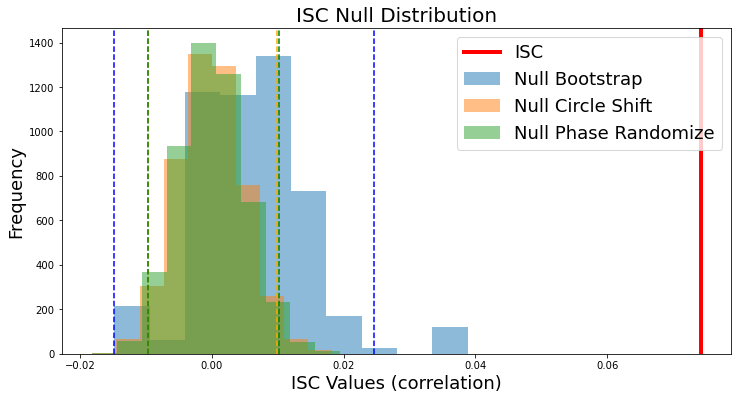

In [66]:
plt.figure(figsize=(12,6))
plt.hist(stats_boot['null_distribution'], alpha=.5)
plt.hist(stats_circle['null_distribution'], alpha=.5)
plt.hist(stats_phase['null_distribution'], alpha=.5)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('ISC Values (correlation)', fontsize=18)
plt.title('ISC Null Distribution', fontsize=20)
plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4)
plt.legend(['ISC', 'Null Bootstrap','Null Circle Shift', 'Null Phase Randomize'], fontsize=18)

plt.axvline(stats_boot['ci'][0], linestyle='--', color='blue')
plt.axvline(stats_boot['ci'][1], linestyle='--', color='blue')

plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange')
plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange')

plt.axvline(stats_phase['ci'][0], linestyle='--', color='green')
plt.axvline(stats_phase['ci'][1], linestyle='--', color='green')

## Write Tests

In [54]:
n_boot = 100
dat = np.random.multivariate_normal([0,0,0,0,0], [[1, .2, .5, .7, .3],
                                                  [.2, 1, .6, .1, .2],
                                                  [.5, .6, 1, .3, .1],
                                                  [.7, .1, .3, 1, .4],
                                                  [.3, .2, .1, .4, 1]], 500)
for method in ['bootstrap', 'circle_shift', 'phase_randomize']:
    for metric in ['median', 'mean']:
        stats = isc(dat, method=method, metric=metric, n_bootstraps=n_boot, return_bootstraps=True)
        assert stats['isc'] > .1
        assert (stats['isc'] > -1) & (stats['isc'] < 1)
        assert (stats['p'] > 0) & (stats['p'] < 1)
        assert len(stats['null_distribution']) == n_boot

In [46]:
type(dat)

numpy.ndarray

In [8]:
roi = 4
data1 = sub_timeseries[sub_list[0]].iloc[:, roi]
data2 = sub_timeseries[sub_list[1]].iloc[:, roi]
data1 = np.array(data1)
data2 = np.array(data2)
random_state=None
random_state = check_random_state(random_state)

sub_data = [sub_timeseries[x].iloc[:, roi].values for x in sub_timeseries]

sub_data = pd.DataFrame({x:sub_timeseries[x].iloc[:, roi] for x in sub_timeseries})

metric = 'correlation'
r = Adjacency(1 - pairwise_distances(sub_data.T, metric=metric), matrix_type='similarity')

stats = r.isc(metric='median', return_bootstraps=False)

In [3]:
def phase_randomize(data):
    '''Perform phase randomization on time-series signal
        
        This procedure preserves the power spectrum/autocorrelation,
        but destroys any nonlinear behavior. Based on the algorithm 
        described in:
        
        Theiler, J., Galdrikian, B., Longtin, A., Eubank, S., & Farmer, J. D. (1991). 
        Testing for nonlinearity in time series: the method of surrogate data 
        (No. LA-UR-91-3343; CONF-9108181-1). Los Alamos National Lab., NM (United States).

        Lancaster, G., Iatsenko, D., Pidde, A., Ticcinelli, V., & Stefanovska, A. (2018). 
        Surrogate data for hypothesis testing of physical systems. Physics Reports, 748, 1-60.
            
        1. Calculate the Fourier transform ftx of the original signal xn.
        2. Generate a vector of random phases in the range[0, 2π]) with 
           length L/2,where L is the length of the time series.
        3. As the Fourier transform is symmetrical, to create the new phase 
           randomized vector ftr , multiply the first half of ftx (i.e.the half 
           corresponding to the positive frequencies) by exp(iφr) to create the 
           first half of ftr.The remainder of ftr is then the horizontally flipped 
           complex conjugate of the first half.
        4. Finally, the inverse Fourier transform of ftr gives the FT surrogate.

        Args:
        
            data: (np.array) data

        Returns:
        
            shifted_data: (np.array) phase randomized data
    '''
    data = np.array(data)
    fft_data = fft(data, axis=0)

    if data.shape[0] % 2 == 0:
        pos_freq = np.arange(1, data.shape[0] // 2)
        neg_freq = np.arange(data.shape[0] - 1, data.shape[0] // 2, -1)
    else:
        pos_freq = np.arange(1, (data.shape[0] - 1) // 2 + 1)
        neg_freq = np.arange(data.shape[0] - 1, (data.shape[0] - 1) // 2, -1)

    phase_shifts = random_state.uniform(0, 2*np.pi, size=(len(pos_freq)))
    fft_data[pos_freq] *= np.exp(1j * phase_shifts)
    fft_data[neg_freq] *= np.exp(-1j * phase_shifts)
    return np.real(ifft(fft_data, axis=0))

def circle_shift(data, random_state=None):
    '''Circle shift data for each feature
        
    Args:
    
        data: time series (1D or 2D). If 2D, then must be observations by features
        random_state = int, None, or np.random.RandomState, default: None
            Initial random seed 
            
    Returns:
    
        shifted data
    
    '''
    random_state = check_random_state(random_state)
    data = np.array(data)
    if len(data.shape) == 1:
        shift = random_state.choice(np.arange(len(data)))
        shifted = np.concatenate((data[-shift:], data[:-shift]))
    else:
        shift = random_state.choice(np.arange(data.shape[0]), size=data.shape[1])
        shifted = np.array([np.concatenate([data[-int(s):, int(d)], data[:-int(s), int(d)]]) for d,s in zip(range(data.shape[1]), shift)]).T
    return shifted
        
    
def correlation_permutation(data1, data2, method='random', n_permute=5000, metric='spearman',
                            tail=2, n_jobs=-1, return_perms=False, random_state=None):
    ''' Permute correlation.

        Args:
        
            data1: (pd.DataFrame, pd.Series, np.array) dataset 1 to permute
            data2: (pd.DataFrame, pd.Series, np.array) dataset 2 to permute
            n_permute: (int) number of permutations
            metric: (str) type of association metric ['spearman','pearson',
                    'kendall']
            method: (str) type of permutation ['random', 'circle_shift', 'phase_scramble']
            random_state = int, None, or np.random.RandomState, default: None
                Initial random seed
            tail: (int) either 1 for one-tail or 2 for two-tailed test (default: 2)
            n_jobs: (int) The number of CPUs to use to do the computation.
                    -1 means all CPUs.
            return_parms: (bool) Return the permutation distribution along with the p-value; default False

        Returns:
        
            stats: (dict) dictionary of permutation results ['correlation','p']

    '''
    if len(data1) != len(data2):
        raise ValueError('Make sure that data1 is the same length as data2')
    
    if method not in ['random', 'circle_shift', 'phase_scramble']:
        raise ValueError("Make sure that method is ['random', 'circle_shift', 'phase_scramble']")

    random_state = check_random_state(random_state)

    data1 = np.array(data1)
    data2 = np.array(data2)

    stats = {'correlation':correlation(data1, data2, metric=metric)[0]}

    if method == 'random':
        all_p = Parallel(n_jobs=n_jobs)(delayed(correlation)(
                        random_state.permutation(data1), data2, metric=metric)
                        for i in range(n_permute))
    elif method == 'circle_shift':
        shift = random_state.choice(np.arange(len(data1)))
        all_p = Parallel(n_jobs=n_jobs)(delayed(correlation)(
                circle_shift(data1, shift), data2, metric=metric)
                for i in range(n_permute))
    elif method == 'phase_scramble':
        all_p = Parallel(n_jobs=n_jobs)(delayed(correlation)(
                phase_randomize(data1), phase_randomize(data2), metric=metric)
                for i in range(n_permute))

    all_p = [x[0] for x in all_p]

    stats['p'] = _calc_pvalue(all_p, stats['correlation'], tail)
    if return_perms:
        stats['perm_dist'] = all_p
    return stats

def _bootstrap_isc(similarity_matrix, metric='median', exclude_self_corr=True, random_state=None):
    '''Helper function to compute bootstrapped ISC from Adjacency Instance

        This function implements the subject-wise bootstrap method discussed in Chen et al., 2016.

        Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., 
        & Cox, R. W. (2016). Untangling the relatedness among correlations, part I: 
        nonparametric approaches to inter-subject correlation analysis at the group level. 
        NeuroImage, 142, 248-259.
        
        Args:
        
            similarity_matrix: (Adjacency) Adjacency matrix of pairwise correlation values
            metric: (str) type of summary statistic (Default: median)
            exclude_self_corr: (bool) set correlations with random draws of same subject to NaN (Default: True)
            random_state: random_state instance for permutation

        Returns:
        
            isc: summary statistic of bootstrapped similarity matrix

    '''
    if not isinstance(similarity_matrix, Adjacency):
        raise ValueError('similarity_matrix must be an Adjacency instance.')
        
    random_state = check_random_state(random_state)

    square = similarity_matrix.squareform()
    n_sub = square.shape[0]
    np.fill_diagonal(square, 1)
    
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    bootstrap_sample = Adjacency(square[bootstrap_subject, :][:, bootstrap_subject], matrix_type='similarity')
    
    if exclude_self_corr:
        bootstrap_sample.data[bootstrap_sample.data == 1] = np.nan

    if metric == 'mean':
        return np.tanh(bootstrap_sample.r_to_z().mean())
    elif metric == 'median':
        return bootstrap_sample.median()
            
def isc(self, n_bootstraps=5000, metric='median', ci_percentile=95, exclude_self_corr=True,
        return_bootstraps=False, tail=2, n_jobs=-1, random_state=None):
    ''' Compute intersubject correlation.
    
        This implementation uses the subject-wise bootstrap method from Chen et al., 2016.
        Instead of recomputing the pairwise ISC using circle_shift or phase_randomization methods,
        this approach uses the computationally more efficient method of bootstrapping the subjects
        and computing a new pairwise similarity matrix with randomly selected subjects with replacement.
        If the same subject is selected multiple times, we set the perfect correlation to a nan with 
        (exclude_self_corr=True). As recommended by Chen et al., 2016, we compute the median pairwise ISC
        by default. However, if the mean is preferred, we compute the mean correlation after performing
        the fisher r-to-z transformation and then convert back to correlations to minimize artificially 
        inflating the correlation values. We compute the p-values using the percentile method using the same
        method in Brainiak.
           
        Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., 
        & Cox, R. W. (2016). Untangling the relatedness among correlations, part I: 
        nonparametric approaches to inter-subject correlation analysis at the group level. 
        NeuroImage, 142, 248-259.
        
        Hall, P., & Wilson, S. R. (1991). Two guidelines for bootstrap hypothesis testing. 
        Biometrics, 757-762.

        Args:
            data1: (pd.DataFrame, pd.Series, np.array) dataset 1 to permute
            data2: (pd.DataFrame, pd.Series, np.array) dataset 2 to permute
            n_bootstraps: (int) number of bootstraps
            metric: (str) type of association metric ['spearman','pearson',
                    'kendall']
            tail: (int) either 1 for one-tail or 2 for two-tailed test (default: 2)
            n_jobs: (int) The number of CPUs to use to do the computation.
                    -1 means all CPUs.
            return_parms: (bool) Return the permutation distribution along with the p-value; default False

        Returns:
            stats: (dict) dictionary of permutation results ['correlation','p']

    '''
    
    random_state = check_random_state(random_state)

    if metric not in ['mean', 'median']:
        raise ValueError("metric must be ['mean', 'median']")

    if metric =='mean':
        isc = np.tanh(self.r_to_z().mean())
    elif metric =='median':
        isc = self.median()
    stats = {'isc': isc}
    
    all_bootstraps = Parallel(n_jobs=n_jobs)(delayed(_bootstrap_isc)(
                self, metric=metric, exclude_self_corr=exclude_self_corr, 
                random_state=random_state) for i in range(n_bootstraps))
    
    stats['p'] = _calc_pvalue(all_bootstraps - stats['isc'], stats['isc'], tail)

    stats['ci'] = (np.percentile(np.array(all_bootstraps), (100 - ci_percentile)/2, axis=0),
                   np.percentile(np.array(all_bootstraps), ci_percentile + (100 - ci_percentile)/2, axis=0))
    
    if return_bootstraps:
        stats['null_distribution'] = all_bootstraps
        
    return stats




In [3]:
roi = 4
data1 = sub_timeseries[sub_list[0]].iloc[:, roi]
data2 = sub_timeseries[sub_list[1]].iloc[:, roi]
data1 = np.array(data1)
data2 = np.array(data2)
random_state=None
random_state = check_random_state(random_state)

sub_data = [sub_timeseries[x].iloc[:, roi].values for x in sub_timeseries]

sub_data = pd.DataFrame({x:sub_timeseries[x].iloc[:, roi] for x in sub_timeseries})

metric = 'correlation'
r = Adjacency(1 - pairwise_distances(sub_data.T, metric=metric), matrix_type='similarity')

stats = r.isc(metric='median', return_bootstraps=False)

In [4]:

stats = r.isc(metric='median', return_bootstraps=False)

In [5]:
stats

{'isc': 0.44960088023898614,
 'p': 0.0001999600079984003,
 'ci': (0.3814575511565328, 0.49010706604770693)}

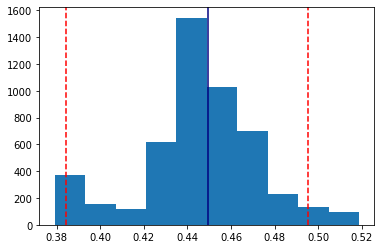

In [19]:
plt.hist(stats['null_distribution'])
plt.axvline(stats['isc'], linestyle='-', color='navy')
plt.axvline(stats['ci'][0], linestyle='--', color='red')
plt.axvline(stats['ci'][1], linestyle='--', color='red')

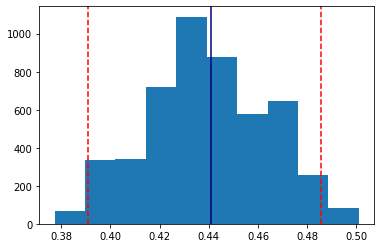

In [21]:
plt.hist(stats['null_distribution'])
plt.axvline(stats['isc'], linestyle='-', color='navy')
plt.axvline(stats['ci'][0], linestyle='--', color='red')
plt.axvline(stats['ci'][1], linestyle='--', color='red')

0.3840919695961391

# Steps for bootstrap ISC

 1. add r to z method - done
 2. add option to compute mean of similarity if values look like correlations using fisher transformation.
 3. add subject bootstrap to Adjacency - done
 4. add median method to Adjacency  - done
 5. add replace method to Adjacency
 
 Notes:
 Should we replace ISC of 1 with nan? seems weird to do by default.

In [4]:
roi = 4
data1 = sub_timeseries[sub_list[0]].iloc[:, roi]
data2 = sub_timeseries[sub_list[1]].iloc[:, roi]
data1 = np.array(data1)
data2 = np.array(data2)
random_state=None
random_state = check_random_state(random_state)



In [5]:
stats_random = correlation_permutation(data1, data2, method='random')
stats_random

random


{'correlation': 0.3610148123499163, 'p': 0.0001999600079984003}

In [6]:
stats_circle = correlation_permutation(data1, data2, method='circle_shift')
stats_circle

circle


{'correlation': 0.3610148123499163, 'p': 0.0001999600079984003}

In [7]:
stats_phase = correlation_permutation(data1, data2, method='phase_scramble')
stats_phase

phase


{'correlation': 0.3610148123499163, 'p': 0.0001999600079984003}

phase


(array([   2.,   35.,  192.,  670., 1269., 1416.,  945.,  388.,   74.,
           9.]),
 array([-0.1466802 , -0.11838581, -0.09009141, -0.06179702, -0.03350263,
        -0.00520824,  0.02308615,  0.05138054,  0.07967493,  0.10796932,
         0.13626371]),
 <a list of 10 Patch objects>)

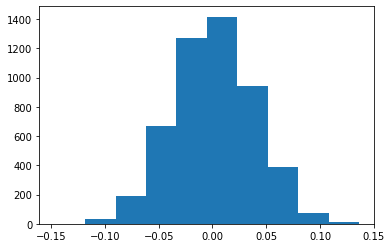

In [9]:
stats_phase = correlation_permutation(data1, data2, method='phase_scramble', return_perms=True)
plt.hist(stats_phase['perm_dist'])

In [ ]:
def timeshift_isc(data, pairwise=False, summary_statistic='median',
                  n_shifts=1000, tolerate_nans=True, random_state=None):

    """Circular time-shift randomization for one-sample ISC test
    For each voxel or ROI, compute the actual ISC and p-values
    from a null distribution of ISCs where response time series
    are first circularly shifted by random intervals. If pairwise,
    apply time-shift randomization to each subjects and compute pairwise
    ISCs. If leave-one-out approach is used (pairwise=False), apply
    the random time-shift to only the left-out subject in each iteration
    of the leave-one-out procedure. Input data should be a list where
    each item is a time-points by voxels ndarray for a given subject.
    Multiple input ndarrays must be the same shape. If a single ndarray is
    supplied, the last dimension is assumed to correspond to subjects.
    When using leave-one-out approach, NaNs are ignored when computing mean
    time series of N-1 subjects (default: tolerate_nans=True). Alternatively,
    you may supply a float between 0 and 1 indicating a threshold proportion
    of N subjects with non-NaN values required when computing the average time
    series for a given voxel. For example, if tolerate_nans=.8, ISCs will be
    computed for any voxel where >= 80% of subjects have non-NaN values,
    while voxels with < 80% non-NaN values will be assigned NaNs. If set to
    False, NaNs are not tolerated and voxels with one or more NaNs among the
    N-1 subjects will be assigned NaN. Setting tolerate_nans to True or False
    will not affect the pairwise approach; however, if a threshold float is
    provided, voxels that do not reach this threshold will be excluded. Note
    that accommodating NaNs may be notably slower than setting tolerate_nans to
    False. Returns the observed ISC and p-values (two-tailed test), as well as
    the null distribution of ISCs computed on randomly time-shifted data.
    The implementation is based on the work in [Kauppi2010]_ and
    [Kauppi2014]_.
    .. [Kauppi2010] "Inter-subject correlation of brain hemodynamic
       responses during watching a movie: localization in space and
       frequency.", J. P. Kauppi, I. P. Jääskeläinen, M. Sams, J. Tohka,
       2010, Frontiers in Neuroinformatics, 4, 5.
       https://doi.org/10.3389/fninf.2010.00005
    Parameters
    ----------
    data : list or ndarray (n_TRs x n_voxels x n_subjects)
        fMRI data for which to compute ISFC
    pairwise : bool, default: False
        Whether to use pairwise (True) or leave-one-out (False) approach
    summary_statistic : str, default: 'median'
        Summary statistic, either 'median' (default) or 'mean'
    n_shifts : int, default: 1000
        Number of randomly shifted samples
    tolerate_nans : bool or float, default: True
        Accommodate NaNs (when averaging in leave-one-out approach)
    random_state = int, None, or np.random.RandomState, default: None
        Initial random seed
    Returns
    -------
    observed : float, observed ISC (without time-shifting)
        Actual ISCs
    p : float, p-value
        p-value based on time-shifting randomization test
    distribution : ndarray, time-shifts by voxels (optional)
        Time-shifted null distribution if return_bootstrap=True
    """

    # Check response time series input format
    data, n_TRs, n_voxels, n_subjects = _check_timeseries_input(data)

    # Get actual observed ISC
    observed = isc(data, pairwise=pairwise,
                   summary_statistic=summary_statistic,
                   tolerate_nans=tolerate_nans)

    # Roll axis to get subjects in first dimension for loop
    if pairwise:
        data = np.rollaxis(data, 2, 0)

    # Iterate through randomized shifts to create null distribution
    distribution = []
    for i in np.arange(n_shifts):

        # Random seed to be deterministically re-randomized at each iteration
        if isinstance(random_state, np.random.RandomState):
            prng = random_state
        else:
            prng = np.random.RandomState(random_state)

        # Get a random set of shifts based on number of TRs,
        shifts = prng.choice(np.arange(n_TRs), size=n_subjects,
                             replace=True)

        # In pairwise approach, apply all shifts then compute pairwise ISCs
        if pairwise:

            # Apply circular shift to each subject's time series
            shifted_data = []
            for subject, shift in zip(data, shifts):
                shifted_data.append(np.concatenate(
                                        (subject[-shift:, :],
                                         subject[:-shift, :])))
            shifted_data = np.dstack(shifted_data)

            # Compute null ISC on shifted data for pairwise approach
            shifted_isc = isc(shifted_data, pairwise=pairwise,
                              summary_statistic=summary_statistic,
                              tolerate_nans=tolerate_nans)

        # In leave-one-out, apply shift only to each left-out participant
        elif not pairwise:

            shifted_isc = []
            for s, shift in enumerate(shifts):
                shifted_subject = np.concatenate((data[-shift:, :, s],
                                                  data[:-shift, :, s]))
                nonshifted_mean = np.mean(np.delete(data, s, 2), axis=2)
                loo_isc = isc(np.dstack((shifted_subject, nonshifted_mean)),
                              pairwise=False,
                              summary_statistic=None,
                              tolerate_nans=tolerate_nans)
                shifted_isc.append(loo_isc)

            # Get summary statistics across left-out subjects
            shifted_isc = compute_summary_statistic(
                                np.dstack(shifted_isc),
                                summary_statistic=summary_statistic,
                                axis=2)

        distribution.append(shifted_isc)

        # Update random state for next iteration
        random_state = np.random.RandomState(prng.randint(0, MAX_RANDOM_SEED))

    # Convert distribution to numpy array
    distribution = np.vstack(distribution)

    # Get p-value for actual median from shifted distribution
    p = p_from_null(observed, distribution,
                    side='two-sided', exact=False,
                    axis=0)

    return observed, p, distribution


def phaseshift_isc(data, pairwise=False, summary_statistic='median',
                   n_shifts=1000, tolerate_nans=True, random_state=None):

    """Phase randomization for one-sample ISC test
    For each voxel or ROI, compute the actual ISC and p-values
    from a null distribution of ISCs where response time series
    are phase randomized prior to computing ISC. If pairwise,
    apply phase randomization to each subject and compute pairwise
    ISCs. If leave-one-out approach is used (pairwise=False), only
    apply phase randomization to the left-out subject in each iteration
    of the leave-one-out procedure. Input data should be a list where
    each item is a time-points by voxels ndarray for a given subject.
    Multiple input ndarrays must be the same shape. If a single ndarray is
    supplied, the last dimension is assumed to correspond to subjects.
    When using leave-one-out approach, NaNs are ignored when computing mean
    time series of N-1 subjects (default: tolerate_nans=True). Alternatively,
    you may supply a float between 0 and 1 indicating a threshold proportion
    of N subjects with non-NaN values required when computing the average time
    series for a given voxel. For example, if tolerate_nans=.8, ISCs will be
    computed for any voxel where >= 80% of subjects have non-NaN values,
    while voxels with < 80% non-NaN values will be assigned NaNs. If set to
    False, NaNs are not tolerated and voxels with one or more NaNs among the
    N-1 subjects will be assigned NaN. Setting tolerate_nans to True or False
    will not affect the pairwise approach; however, if a threshold float is
    provided, voxels that do not reach this threshold will be excluded. Note
    that accommodating NaNs may be notably slower than setting tolerate_nans to
    False. Returns the observed ISC and p-values (two-tailed test), as well as
    the null distribution of ISCs computed on phase-randomized data.
    The implementation is based on the work in [Lerner2011]_ and
    [Simony2016]_.
    .. [Lerner2011] "Topographic mapping of a hierarchy of temporal
       receptive windows using a narrated story.", Y. Lerner, C. J. Honey,
       L. J. Silbert, U. Hasson, 2011, Journal of Neuroscience, 31, 2906-2915.
       https://doi.org/10.1523/jneurosci.3684-10.2011
    Parameters
    ----------
    data : list or ndarray (n_TRs x n_voxels x n_subjects)
        fMRI data for which to compute ISFC
    pairwise : bool, default: False
        Whether to use pairwise (True) or leave-one-out (False) approach
    summary_statistic : str, default: 'median'
        Summary statistic, either 'median' (default) or 'mean'
    n_shifts : int, default: 1000
        Number of randomly shifted samples
    tolerate_nans : bool or float, default: True
        Accommodate NaNs (when averaging in leave-one-out approach)
    random_state = int, None, or np.random.RandomState, default: None
        Initial random seed
    Returns
    -------
    observed : float, observed ISC (without time-shifting)
        Actual ISCs
    p : float, p-value
        p-value based on time-shifting randomization test
    distribution : ndarray, time-shifts by voxels (optional)
        Time-shifted null distribution if return_bootstrap=True
    """

    # Check response time series input format
    data, n_TRs, n_voxels, n_subjects = _check_timeseries_input(data)

    # Get actual observed ISC
    observed = isc(data, pairwise=pairwise,
                   summary_statistic=summary_statistic,
                   tolerate_nans=tolerate_nans)

    # Iterate through randomized shifts to create null distribution
    distribution = []
    for i in np.arange(n_shifts):

        # Random seed to be deterministically re-randomized at each iteration
        if isinstance(random_state, np.random.RandomState):
            prng = random_state
        else:
            prng = np.random.RandomState(random_state)

        # Get shifted version of data
        shifted_data = phase_randomize(data, random_state=prng)

        # In pairwise approach, apply all shifts then compute pairwise ISCs
        if pairwise:

            # Compute null ISC on shifted data for pairwise approach
            shifted_isc = isc(shifted_data, pairwise=True,
                              summary_statistic=summary_statistic,
                              tolerate_nans=tolerate_nans)

        # In leave-one-out, apply shift only to each left-out participant
        elif not pairwise:

            # Roll subject axis of phase-randomized data
            shifted_data = np.rollaxis(shifted_data, 2, 0)

            shifted_isc = []
            for s, shifted_subject in enumerate(shifted_data):

                # ISC of shifted left-out subject vs mean of N-1 subjects
                nonshifted_mean = np.mean(np.delete(data, s, axis=2),
                                          axis=2)
                loo_isc = isc(np.dstack((shifted_subject, nonshifted_mean)),
                              pairwise=False, summary_statistic=None,
                              tolerate_nans=tolerate_nans)
                shifted_isc.append(loo_isc)

            # Get summary statistics across left-out subjects
            shifted_isc = compute_summary_statistic(
                            np.dstack(shifted_isc),
                            summary_statistic=summary_statistic, axis=2)
        distribution.append(shifted_isc)

        # Update random state for next iteration
        random_state = np.random.RandomState(prng.randint(0, MAX_RANDOM_SEED))

    # Convert distribution to numpy array
    distribution = np.vstack(distribution)

    # Get p-value for actual median from shifted distribution
    p = p_from_null(observed, distribution,
                    side='two-sided', exact=False,
                    axis=0)

    return observed, p, distribution

In [ ]:
"""
This file contains select routines for isc analysis copied from brainiak. Functions are copied here to keep the dependencies of this package lighter (i.e. avoiding the need the install _all_ of brainiak)

Kumar, M., Ellis, C. T., Lu, Q., Zhang, H., Capota, M., Willke, T. L., Ramadge, P. J., Turk-Browne, N.B., Norman, K. (2019). BrainIAK tutorials: user-friendly learning materials for advanced fMRI analysis. 

#  Copyright 2017 Intel Corporation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

"""

import numpy as np
from scipy.spatial.distance import squareform
from itertools import permutations, product

MAX_RANDOM_SEED = 2 ** 32 - 1


def p_from_null(observed, distribution, side="two-sided", exact=False, axis=None):
    """Compute p-value from null distribution
    Returns the p-value for an observed test statistic given a null
    distribution. Performs either a 'two-sided' (i.e., two-tailed)
    test (default) or a one-sided (i.e., one-tailed) test for either the
    'left' or 'right' side. For an exact test (exact=True), does not adjust
    for the observed test statistic; otherwise, adjusts for observed
    test statistic (prevents p-values of zero). If a multidimensional
    distribution is provided, use axis argument to specify which axis indexes
    resampling iterations.
    The implementation is based on the work in [PhipsonSmyth2010]_.
    .. [PhipsonSmyth2010] "Permutation p-values should never be zero:
       calculating exact p-values when permutations are randomly drawn.",
       B. Phipson, G. K., Smyth, 2010, Statistical Applications in Genetics
       and Molecular Biology, 9, 1544-6115.
       https://doi.org/10.2202/1544-6115.1585
    Parameters
    ----------
    observed : float
        Observed test statistic
    distribution : ndarray
        Null distribution of test statistic
    side : str, default:'two-sided'
        Perform one-sided ('left' or 'right') or 'two-sided' test
    axis: None or int, default:None
        Axis indicating resampling iterations in input distribution
    Returns
    -------
    p : float
        p-value for observed test statistic based on null distribution
    """

    if side not in ("two-sided", "left", "right"):
        raise ValueError(
            "The value for 'side' must be either "
            "'two-sided', 'left', or 'right', got {0}".format(side)
        )

    n_samples = len(distribution)

    if side == "two-sided":
        # Numerator for two-sided test
        numerator = np.sum(np.abs(distribution) >= np.abs(observed), axis=axis)
    elif side == "left":
        # Numerator for one-sided test in left tail
        numerator = np.sum(distribution <= observed, axis=axis)
    elif side == "right":
        # Numerator for one-sided test in right tail
        numerator = np.sum(distribution >= observed, axis=axis)

    # If exact test all possible permutations and do not adjust
    if exact:
        p = numerator / n_samples

    # If not exact test, adjust number of samples to account for
    # observed statistic; prevents p-value from being zero
    else:
        p = (numerator + 1) / (n_samples + 1)

    return p


def _check_isc_input(iscs, pairwise=False):

    """Checks ISC inputs for statistical tests
    Input ISCs should be n_subjects (leave-one-out approach) or
    n_pairs (pairwise approach) by n_voxels or n_ROIs array or a 1D
    array (or list) of ISC values for a single voxel or ROI. This
    function is only intended to be used internally by other
    functions in this module (e.g., bootstrap_isc, permutation_isc).
    Parameters
    ----------
    iscs : ndarray or list
        ISC values
    Returns
    -------
    iscs : ndarray
        Array of ISC values
    n_subjects : int
        Number of subjects
    n_voxels : int
        Number of voxels (or ROIs)
    """

    # Standardize structure of input data
    if type(iscs) == list:
        iscs = np.array(iscs)[:, np.newaxis]

    elif isinstance(iscs, np.ndarray):
        if iscs.ndim == 1:
            iscs = iscs[:, np.newaxis]

    # Check if incoming pairwise matrix is vectorized triangle
    if pairwise:
        try:
            test_square = squareform(iscs[:, 0])
            n_subjects = test_square.shape[0]
        except ValueError:
            raise ValueError(
                "For pairwise input, ISCs must be the "
                "vectorized triangle of a square matrix."
            )
    elif not pairwise:
        n_subjects = iscs.shape[0]

    # Infer subjects, voxels and print for user to check
    n_voxels = iscs.shape[1]

    return iscs, n_subjects, n_voxels


def compute_summary_statistic(iscs, summary_statistic="mean", axis=None):

    """Computes summary statistics for ISCs
    Computes either the 'mean' or 'median' across a set of ISCs. In the
    case of the mean, ISC values are first Fisher Z transformed (arctanh),
    averaged, then inverse Fisher Z transformed (tanh).
    The implementation is based on the work in [SilverDunlap1987]_.
    .. [SilverDunlap1987] "Averaging corrlelation coefficients: should
       Fisher's z transformation be used?", N. C. Silver, W. P. Dunlap, 1987,
       Journal of Applied Psychology, 72, 146-148.
       https://doi.org/10.1037/0021-9010.72.1.146
    Parameters
    ----------
    iscs : list or ndarray
        ISC values
    summary_statistic : str, default: 'mean'
        Summary statistic, 'mean' or 'median'
    axis : None or int or tuple of ints, optional
        Axis or axes along which the means are computed. The default is to
        compute the mean of the flattened array.
    Returns
    -------
    statistic : float or ndarray
        Summary statistic of ISC values
    """

    if summary_statistic not in ("mean", "median"):
        raise ValueError("Summary statistic must be 'mean' or 'median'")

    # Compute summary statistic
    if summary_statistic == "mean":
        statistic = np.tanh(np.nanmean(np.arctanh(iscs), axis=axis))
    elif summary_statistic == "median":
        statistic = np.nanmedian(iscs, axis=axis)

    return statistic


def bootstrap_isc(
    iscs,
    pairwise=False,
    summary_statistic="median",
    n_bootstraps=1000,
    ci_percentile=95,
    random_state=None,
):

    """One-sample group-level bootstrap hypothesis test for ISCs
    For ISCs from one more voxels or ROIs, resample subjects with replacement
    to construct a bootstrap distribution. Input is a list or ndarray of
    ISCs for a single voxel/ROI, or an ISCs-by-voxels ndarray. ISC values
    should be either N ISC values for N subjects in the leave-one-out appraoch
    (pairwise=False), N(N-1)/2 ISC values for N subjects in the pairwise
    approach (pairwise=True). In the pairwise approach, ISC values should
    correspond to the vectorized upper triangle of a square corrlation matrix
    (see scipy.stats.distance.squareform). Shifts bootstrap distribution by
    actual summary statistic (effectively to zero) for two-tailed null
    hypothesis test (Hall & Wilson, 1991). Uses subject-wise (not pair-wise)
    resampling in the pairwise approach. Returns the observed ISC, the
    confidence interval, and a p-value for the bootstrap hypothesis test, as
    well as the bootstrap distribution of summary statistics. According to
    Chen et al., 2016, this is the preferred nonparametric approach for
    controlling false positive rates (FPR) for one-sample tests in the pairwise
    approach.
    The implementation is based on the work in [Chen2016]_ and
    [HallWilson1991]_.
    .. [HallWilson1991] "Two guidelines for bootstrap hypothesis testing.",
       P. Hall, S. R., Wilson, 1991, Biometrics, 757-762.
       https://doi.org/10.2307/2532163
    Parameters
    ----------
    iscs : list or ndarray, ISCs by voxels array
        ISC values for one or more voxels
    pairwise : bool, default: False
        Indicator of pairwise or leave-one-out, should match ISCs structure
    summary_statistic : str, default: 'median'
        Summary statistic, either 'median' (default) or 'mean'
    n_bootstraps : int, default: 1000
        Number of bootstrap samples (subject-level with replacement)
    ci_percentile : int, default: 95
         Percentile for computing confidence intervals
    random_state = int or None, default: None
        Initial random seed
    Returns
    -------
    observed : float, median (or mean) ISC value
        Summary statistic for actual ISCs
    ci : tuple, bootstrap confidence intervals
        Confidence intervals generated from bootstrap distribution
    p : float, p-value
        p-value based on bootstrap hypothesis test
    distribution : ndarray, bootstraps by voxels (optional)
        Bootstrap distribution if return_bootstrap=True
    """

    # Standardize structure of input data
    iscs, n_subjects, n_voxels = _check_isc_input(iscs, pairwise=pairwise)

    # Check for valid summary statistic
    if summary_statistic not in ("mean", "median"):
        raise ValueError("Summary statistic must be 'mean' or 'median'")

    # Compute summary statistic for observed ISCs
    observed = compute_summary_statistic(
        iscs, summary_statistic=summary_statistic, axis=0
    )

    # Set up an empty list to build our bootstrap distribution
    distribution = []

    # Loop through n bootstrap iterations and populate distribution
    for i in np.arange(n_bootstraps):

        # Random seed to be deterministically re-randomized at each iteration
        if isinstance(random_state, np.random.RandomState):
            prng = random_state
        else:
            prng = np.random.RandomState(random_state)

        # Randomly sample subject IDs with replacement
        subject_sample = sorted(prng.choice(np.arange(n_subjects), size=n_subjects))

        # Squareform and shuffle rows/columns of pairwise ISC matrix to
        # to retain correlation structure among ISCs, then get triangle
        if pairwise:

            # Loop through voxels
            isc_sample = []
            for voxel_iscs in iscs.T:

                # Square the triangle and fill diagonal
                voxel_iscs = squareform(voxel_iscs)
                np.fill_diagonal(voxel_iscs, 1)

                # Check that pairwise ISC matrix is square and symmetric
                assert voxel_iscs.shape[0] == voxel_iscs.shape[1]
                assert np.allclose(voxel_iscs, voxel_iscs.T)

                # Shuffle square correlation matrix and get triangle
                voxel_sample = voxel_iscs[subject_sample, :][:, subject_sample]
                voxel_sample = squareform(voxel_sample, checks=False)

                # Censor off-diagonal 1s for same-subject pairs
                voxel_sample[voxel_sample == 1.0] = np.NaN

                isc_sample.append(voxel_sample)

            isc_sample = np.column_stack(isc_sample)

        # Get simple bootstrap sample if not pairwise
        elif not pairwise:
            isc_sample = iscs[subject_sample, :]

        # Compute summary statistic for bootstrap ISCs per voxel
        # (alternatively could construct distribution for all voxels
        # then compute statistics, but larger memory footprint)
        distribution.append(
            compute_summary_statistic(
                isc_sample, summary_statistic=summary_statistic, axis=0
            )
        )

        # Update random state for next iteration
        random_state = np.random.RandomState(prng.randint(0, MAX_RANDOM_SEED))

    # Convert distribution to numpy array
    distribution = np.array(distribution)

    # Compute CIs of median from bootstrap distribution (default: 95%)
    ci = (
        np.percentile(distribution, (100 - ci_percentile) / 2, axis=0),
        np.percentile(distribution, ci_percentile + (100 - ci_percentile) / 2, axis=0),
    )

    # Shift bootstrap distribution to 0 for hypothesis test
    shifted = distribution - observed

    # Get p-value for actual median from shifted distribution
    p = p_from_null(observed, shifted, side="two-sided", exact=False, axis=0)

    return observed, ci, p, distribution


def _permute_one_sample_iscs(
    iscs,
    group_parameters,
    i,
    pairwise=False,
    summary_statistic="median",
    group_matrix=None,
    exact_permutations=None,
    prng=None,
):

    """Applies one-sample permutations to ISC data
    Input ISCs should be n_subjects (leave-one-out approach) or
    n_pairs (pairwise approach) by n_voxels or n_ROIs array.
    This function is only intended to be used internally by the
    permutation_isc function in this module.
    Parameters
    ----------
    iscs : ndarray or list
        ISC values
    group_parameters : dict
        Dictionary of group parameters
    i : int
        Permutation iteration
    pairwise : bool, default: False
        Indicator of pairwise or leave-one-out, should match ISCs variable
    summary_statistic : str, default: 'median'
        Summary statistic, either 'median' (default) or 'mean'
    exact_permutations : list
        List of permutations
    prng = None or np.random.RandomState, default: None
        Initial random seed
    Returns
    -------
    isc_sample : ndarray
        Array of permuted ISC values
    """

    # Randomized sign-flips
    if exact_permutations:
        sign_flipper = np.array(exact_permutations[i])
    else:
        sign_flipper = prng.choice(
            [-1, 1], size=group_parameters["n_subjects"], replace=True
        )

    # If pairwise, apply sign-flips by rows and columns
    if pairwise:
        matrix_flipped = (
            group_parameters["group_matrix"]
            * sign_flipper
            * sign_flipper[:, np.newaxis]
        )
        sign_flipper = squareform(matrix_flipped, checks=False)

    # Apply flips along ISC axis (same across voxels)
    isc_flipped = iscs * sign_flipper[:, np.newaxis]

    # Get summary statistics on sign-flipped ISCs
    isc_sample = compute_summary_statistic(
        isc_flipped, summary_statistic=summary_statistic, axis=0
    )

    return isc_sample


def _permute_two_sample_iscs(
    iscs,
    group_parameters,
    i,
    pairwise=False,
    summary_statistic="median",
    exact_permutations=None,
    prng=None,
):

    """Applies two-sample permutations to ISC data
    Input ISCs should be n_subjects (leave-one-out approach) or
    n_pairs (pairwise approach) by n_voxels or n_ROIs array.
    This function is only intended to be used internally by the
    permutation_isc function in this module.
    Parameters
    ----------
    iscs : ndarray or list
        ISC values
    group_parameters : dict
        Dictionary of group parameters
    i : int
        Permutation iteration
    pairwise : bool, default: False
        Indicator of pairwise or leave-one-out, should match ISCs variable
    summary_statistic : str, default: 'median'
        Summary statistic, either 'median' (default) or 'mean'
    exact_permutations : list
        List of permutations
    prng = None or np.random.RandomState, default: None
        Initial random seed
        Indicator of pairwise or leave-one-out, should match ISCs variable
    Returns
    -------
    isc_sample : ndarray
        Array of permuted ISC values
    """

    # Shuffle the group assignments
    if exact_permutations:
        group_shuffler = np.array(exact_permutations[i])
    elif not exact_permutations and pairwise:
        group_shuffler = prng.permutation(
            np.arange(
                len(
                    np.array(group_parameters["group_assignment"])[
                        group_parameters["sorter"]
                    ]
                )
            )
        )
    elif not exact_permutations and not pairwise:
        group_shuffler = prng.permutation(
            np.arange(len(group_parameters["group_assignment"]))
        )

    # If pairwise approach, convert group assignments to matrix
    if pairwise:

        # Apply shuffler to group matrix rows/columns
        group_shuffled = group_parameters["group_matrix"][group_shuffler, :][
            :, group_shuffler
        ]

        # Unsort shuffled matrix and squareform to create selector
        group_selector = squareform(
            group_shuffled[group_parameters["unsorter"], :][
                :, group_parameters["unsorter"]
            ],
            checks=False,
        )

    # Shuffle group assignments in leave-one-out two sample test
    elif not pairwise:

        # Apply shuffler to group matrix rows/columns
        group_selector = np.array(group_parameters["group_assignment"])[group_shuffler]

    # Get difference of within-group summary statistics
    # with group permutation
    isc_sample = compute_summary_statistic(
        iscs[group_selector == group_parameters["group_labels"][0], :],
        summary_statistic=summary_statistic,
        axis=0,
    ) - compute_summary_statistic(
        iscs[group_selector == group_parameters["group_labels"][1], :],
        summary_statistic=summary_statistic,
        axis=0,
    )

    return isc_sample


def _check_group_assignment(group_assignment, n_subjects):
    if type(group_assignment) == list:
        pass
    elif type(group_assignment) == np.ndarray:
        group_assignment = group_assignment.tolist()

    if group_assignment and len(group_assignment) != n_subjects:
        raise ValueError(
            "Group assignments ({0}) "
            "do not match number of subjects ({1})!".format(
                len(group_assignment), n_subjects
            )
        )
    return group_assignment


def _get_group_parameters(group_assignment, n_subjects, pairwise=False):

    # Set up dictionary to contain group info
    group_parameters = {
        "group_assignment": group_assignment,
        "n_subjects": n_subjects,
        "group_labels": None,
        "groups": None,
        "sorter": None,
        "unsorter": None,
        "group_matrix": None,
        "group_selector": None,
    }

    # Set up group selectors for two-group scenario
    if group_assignment and len(np.unique(group_assignment)) == 2:
        group_parameters["n_groups"] = 2

        # Get group labels and counts
        group_labels = np.unique(group_assignment)
        groups = {
            group_labels[0]: group_assignment.count(group_labels[0]),
            group_labels[1]: group_assignment.count(group_labels[1]),
        }

        # For two-sample pairwise approach set up selector from matrix
        if pairwise:
            # Sort the group_assignment variable if it came in shuffled
            # so it's easier to build group assignment matrix
            sorter = np.array(group_assignment).argsort()
            unsorter = np.array(group_assignment).argsort().argsort()

            # Populate a matrix with group assignments
            upper_left = np.full(
                (groups[group_labels[0]], groups[group_labels[0]]), group_labels[0]
            )
            upper_right = np.full(
                (groups[group_labels[0]], groups[group_labels[1]]), np.nan
            )
            lower_left = np.full(
                (groups[group_labels[1]], groups[group_labels[0]]), np.nan
            )
            lower_right = np.full(
                (groups[group_labels[1]], groups[group_labels[1]]), group_labels[1]
            )
            group_matrix = np.vstack(
                (
                    np.hstack((upper_left, upper_right)),
                    np.hstack((lower_left, lower_right)),
                )
            )
            np.fill_diagonal(group_matrix, np.nan)
            group_parameters["group_matrix"] = group_matrix

            # Unsort matrix and squareform to create selector
            group_parameters["group_selector"] = squareform(
                group_matrix[unsorter, :][:, unsorter], checks=False
            )
            group_parameters["sorter"] = sorter
            group_parameters["unsorter"] = unsorter

        # If leave-one-out approach, just user group assignment as selector
        else:
            group_parameters["group_selector"] = group_assignment

        # Save these parameters for later
        group_parameters["groups"] = groups
        group_parameters["group_labels"] = group_labels

    # Manage one-sample and incorrect group assignments
    elif not group_assignment or len(np.unique(group_assignment)) == 1:
        group_parameters["n_groups"] = 1

        # If pairwise initialize matrix of ones for sign-flipping
        if pairwise:
            group_parameters["group_matrix"] = np.ones(
                (group_parameters["n_subjects"], group_parameters["n_subjects"])
            )

    elif len(np.unique(group_assignment)) > 2:
        raise ValueError(
            "This test is not valid for more than "
            "2 groups! (got {0})".format(len(np.unique(group_assignment)))
        )
    else:
        raise ValueError("Invalid group assignments!")

    return group_parameters


def permutation_isc(
    iscs,
    group_assignment=None,
    pairwise=False,  # noqa: C901
    summary_statistic="median",
    n_permutations=1000,
    random_state=None,
):

    """Group-level permutation test for ISCs
    For ISCs from one or more voxels or ROIs, permute group assignments to
    construct a permutation distribution. Input is a list or ndarray of
    ISCs  for a single voxel/ROI, or an ISCs-by-voxels ndarray. If two groups,
    ISC values should stacked along first dimension (vertically), and a
    group_assignment list (or 1d array) of same length as the number of
    subjects should be provided to indicate groups. If no group_assignment
    is provided, one-sample test is performed using a sign-flipping procedure.
    Performs exact test if number of possible permutations (2**N for one-sample
    sign-flipping, N! for two-sample shuffling) is less than or equal to number
    of requested permutation; otherwise, performs approximate permutation test
    using Monte Carlo resampling. ISC values should either be N ISC values for
    N subjects in the leave-one-out approach (pairwise=False) or N(N-1)/2 ISC
    values for N subjects in the pairwise approach (pairwise=True). In the
    pairwise approach, ISC values should correspond to the vectorized upper
    triangle of a square corrlation matrix (scipy.stats.distance.squareform).
    Note that in the pairwise approach, group_assignment order should match the
    row/column order of the subject-by-subject square ISC matrix even though
    the input ISCs should be supplied as the vectorized upper triangle of the
    square ISC matrix. Returns the observed ISC and permutation-based p-value
    (two-tailed test), as well as the permutation distribution of summary
    statistic. According to Chen et al., 2016, this is the preferred
    nonparametric approach for controlling false positive rates (FPR) for
    two-sample tests. This approach may yield inflated FPRs for one-sample
    tests.
    The implementation is based on the work in [Chen2016]_.
    Parameters
    ----------
    iscs : list or ndarray, correlation matrix of ISCs
        ISC values for one or more voxels
    group_assignment : list or ndarray, group labels
        Group labels matching order of ISC input
    pairwise : bool, default: False
        Indicator of pairwise or leave-one-out, should match ISCs variable
    summary_statistic : str, default: 'median'
        Summary statistic, either 'median' (default) or 'mean'
    n_permutations : int, default: 1000
        Number of permutation iteration (randomizing group assignment)
    random_state = int, None, or np.random.RandomState, default: None
        Initial random seed
    Returns
    -------
    observed : float, ISC summary statistic or difference
        Actual ISC or group difference (excluding between-group ISCs)
    p : float, p-value
        p-value based on permutation test
    distribution : ndarray, permutations by voxels (optional)
        Permutation distribution if return_bootstrap=True
    """

    # Standardize structure of input data
    iscs, n_subjects, n_voxels = _check_isc_input(iscs, pairwise=pairwise)

    # Check for valid summary statistic
    if summary_statistic not in ("mean", "median"):
        raise ValueError("Summary statistic must be 'mean' or 'median'")

    # Check match between group labels and ISCs
    group_assignment = _check_group_assignment(group_assignment, n_subjects)

    # Get group parameters
    group_parameters = _get_group_parameters(
        group_assignment, n_subjects, pairwise=pairwise
    )

    # Set up permutation type (exact or Monte Carlo)
    if group_parameters["n_groups"] == 1:
        if n_permutations < 2 ** n_subjects:
            exact_permutations = None
        else:
            exact_permutations = list(product([-1, 1], repeat=n_subjects))
            n_permutations = 2 ** n_subjects

    # Check for exact test for two groups
    else:
        if n_permutations < np.math.factorial(n_subjects):
            exact_permutations = None
        else:
            exact_permutations = list(permutations(np.arange(len(group_assignment))))
            n_permutations = np.math.factorial(n_subjects)

    # If one group, just get observed summary statistic
    if group_parameters["n_groups"] == 1:
        observed = compute_summary_statistic(
            iscs, summary_statistic=summary_statistic, axis=0
        )[np.newaxis, :]

    # If two groups, get the observed difference
    else:
        observed = compute_summary_statistic(
            iscs[
                group_parameters["group_selector"]
                == group_parameters["group_labels"][0],
                :,
            ],
            summary_statistic=summary_statistic,
            axis=0,
        ) - compute_summary_statistic(
            iscs[
                group_parameters["group_selector"]
                == group_parameters["group_labels"][1],
                :,
            ],
            summary_statistic=summary_statistic,
            axis=0,
        )
        observed = np.array(observed)

    # Set up an empty list to build our permutation distribution
    distribution = []

    # Loop through n permutation iterations and populate distribution
    for i in np.arange(n_permutations):

        # Random seed to be deterministically re-randomized at each iteration
        if exact_permutations:
            prng = None
        elif isinstance(random_state, np.random.RandomState):
            prng = random_state
        else:
            prng = np.random.RandomState(random_state)

        # If one group, apply sign-flipping procedure
        if group_parameters["n_groups"] == 1:
            isc_sample = _permute_one_sample_iscs(
                iscs,
                group_parameters,
                i,
                pairwise=pairwise,
                summary_statistic=summary_statistic,
                exact_permutations=exact_permutations,
                prng=prng,
            )

        # If two groups, set up group matrix get the observed difference
        else:
            isc_sample = _permute_two_sample_iscs(
                iscs,
                group_parameters,
                i,
                pairwise=pairwise,
                summary_statistic=summary_statistic,
                exact_permutations=exact_permutations,
                prng=prng,
            )

        # Tack our permuted ISCs onto the permutation distribution
        distribution.append(isc_sample)

        # Update random state for next iteration
        if not exact_permutations:
            random_state = np.random.RandomState(prng.randint(0, MAX_RANDOM_SEED))

    # Convert distribution to numpy array
    distribution = np.array(distribution)

    # Get p-value for actual median from shifted distribution
    if exact_permutations:
        p = p_from_null(observed, distribution, side="two-sided", exact=True, axis=0)
    else:
        p = p_from_null(observed, distribution, side="two-sided", exact=False, axis=0)

    return observed, p, distribution


# Upsample/Downsample

In [13]:
from nltools.stats import upsample as _upsample
from nltools.stats import downsample as _downsample
from scipy.interpolate import interp1d

data = Brain_Data('/Volumes/Engram/Data/Sherlock/fmriprep/sub-01/func/sub-01_denoise_crop_smooth6mm_task-sherlockPart1_space-MNI152NLin2009cAsym_desc-preproc_bold.hdf5')
data = data[:500]

In [11]:
small.shape

(500, 5)

In [12]:
data.data.shape

(500, 238955)

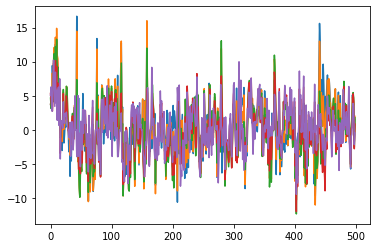

In [5]:
small = data.data[:,1000:1005]

plt.plot(small)

In [ ]:
tr = 1.5
self = data.copy()

def upsample(self, sampling_freq=None, target=None, target_type='hz', method='linear'):
    ''' Upsample Brain_Data timeseries to a new target frequency or number of samples using interpolation.

        Args:
            sampling_freq:  (float) sampling frequency of data in hertz
            target: (float) upsampling target
            target_type: (str) type of target can be [samples,seconds,hz]
            method: (str) ['linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic']
                          where 'zero', 'slinear', 'quadratic' and 'cubic'
                          refer to a spline interpolation of zeroth, first,
                          second or third order  (default: linear)
        Returns:
            upsampled Brain_Data instance
    '''
    out = self.copy()
    out.data = _upsample(pd.DataFrame(out.data), sampling_freq=sampling_freq, target=target, target_type=target_type, method=method)
    return out

upsampled = upsample(self, sampling_freq=1/tr, target=10)
    # upsampled = upsample(pd.DataFrame(data.data).T, sampling_freq=1/tr, target=10, target_type='hz', method='cubic')

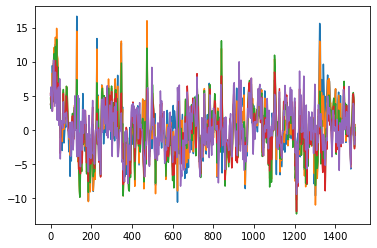

In [10]:
plt.plot(upsampled)

In [ ]:
ups